# JAX Recipe III: Multi-class predictions with correlation (Multivariate Probit)

In this recipe we will explore how to use JAX to fit multivariate probit models. For one dimensional target response, probit models can be seen as a logistic regression with a different link function (probit - the cdf of a normal distribution vs logit function). When analysing multivariate data, those models have the additional potential of estimating the correlation structure between multiple response variables, even after conditioning on all covariates. This can make those models robust to missing covariates that would be predictive of multiple outcomes.

For example, let's imagine that we are interested in modeling a population that can go to two nearby stores, we can record a limited set of covariates (say age, gender, income) and the visits of each individual ($y_1, y_2 \in \{0, 1\}$) to each respective store. Since the stores are close by, it is pretty clear that being able to go to the first one will positively impact the possibility of going to the second one, even after demographic covariates have been taken into account.
From a modeling perspective we could argue that there exists a latent variable that we could interpret as "possibility to go to the area close to the two stores" that is not fully explained by known covariates, and that has a significant impact on each response.

Those models are interesting in the cases where we need to query the joint distribution between binary responses.
E.g. answering questions like: how much does going to the first store increase the probability of going to the second store?
Or what is the probability to going to none of the stores?

While doing exploring those models, several interesting and more general topics will pop up:
- Optimization of a stochastic loss
- Speeding up optimization when loss is slow to compute
- Building confidence intervals for optimizers of those problems
- Rejection sampling using compiled JAX code
- Use of sampling for Monte-Carlo EM methods


## Model specification

### Notations

Here, we are therefore interested in a multivariate binary response $y \in R^{n \times q}$ where $n$ is the sample size, and $q$ is the number of responses of interest.
Here, we will study $q=2$, but the approach will remain general.

We are given a set of $p$ covariates for each sample, which we will concatenate in a single design matrix $X \in R^{n \times p}$.
Those covariates have an influence on each response through some linear parameters $\beta \in R^{p \times q}$.

The noise in the model will come from correlated residuals $\epsilon_i \sim N(0, \Sigma)$ with $\Sigma \in R^{q \times q}$ for $i \in \{ 1, ..., n \}$.

Let's define the _continuous response_ $y^* = X \beta + \epsilon $. Note that, to keep notations close to a univariate regression, we will keep lowercase letters, eventhough all quantities involved are now matrices.

The binary _observed_ response is gotten by setting $y$ to $1$ if $y^*$ is positive, and $0$ otherwise.

More formally, $y_{i,j} = 1(y^*_{i, j} \gt 0)$ for $i = 1, ..., n$ and $j = 1, ..., p$

The discretization creates a slight identification problem between $\Sigma$ and $\beta$, since doubling $\beta$ and the noise leads to the same distribution for $y$.
That is solved by constraining $\Sigma$'s diagonal to $1$'s.

### Interpretation

While familiar in places, this specification can seem a little cryptic at first. The first thing to realize is that for each response it can be simplified to a univariate probit regression:
$$ P(y_1 = 1) = P(y^*_1 > 0) = P( (X \beta)_1 + \epsilon_1 > 0) = P( \epsilon_1 > -(X \beta)_1) = \Phi((X \beta)_1) $$
(Since $\epsilon_1$ is a univariate standard normal.), where $\Phi$ is the cdf of a standard normal.
This is the same thing as a logistic regression with a probit link instead of a logit link.

This has the non-trivial implication that the lines of $\beta$ can be estimated independently via separate univariate probit regressions. We could also add another response to the model as needed (in the example, a third store), and not start from a completely new, unestimated model. This, however, does not tell us how to fit the correlation matrix.


## Generating data

Let's sample some data to play with and understand how to fit and use those models.


In [1]:
import jax
import jax.random as random
import jax.numpy as jnp
import matplotlib.pyplot as plt
from typing import NamedTuple, Any


plt.style.use('ggplot')

In [2]:
# Sample data
key = random.PRNGKey(20220526)

n = 10_000 # Sample size
p = 10 # Predictor
q = 2 # Targets

key, skey = random.split(key)
x = random.normal(skey, (n, p))

key, skey = random.split(key)
beta = random.normal(skey, (p, q))

# Covariance matrix
rho = 0.9
sigma = jnp.array([
    [1.0, rho],
    [rho, 1.0],
])
u = jnp.real(jax.scipy.linalg.sqrtm(sigma))

r = sigma / (1 - rho) - jnp.eye(q)
sqrt_r = jnp.real(jax.scipy.linalg.sqrtm(r))

key, skey = random.split(key)
eps = random.normal(skey, (n, q)) @ u

y_star_mu = x @ beta + eps
y = (y_star_mu >= 0).astype('int32')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[[0.99999994 0.8991772 ]
 [0.8991772  1.        ]]


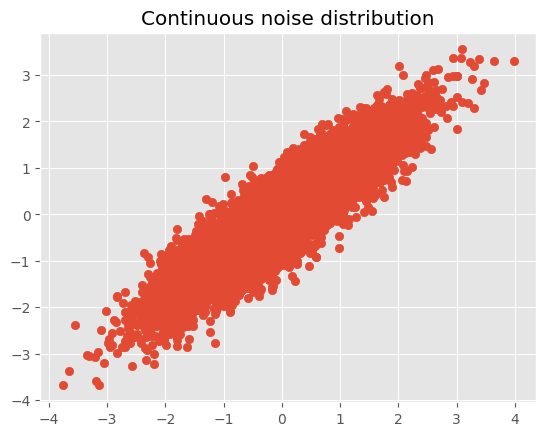

In [3]:
plt.scatter(eps[:, 0], eps[:, 1])
print(jnp.corrcoef(eps.T))
plt.title("Continuous noise distribution")
plt.show()

[[1.         0.37207174]
 [0.37207174 1.        ]]


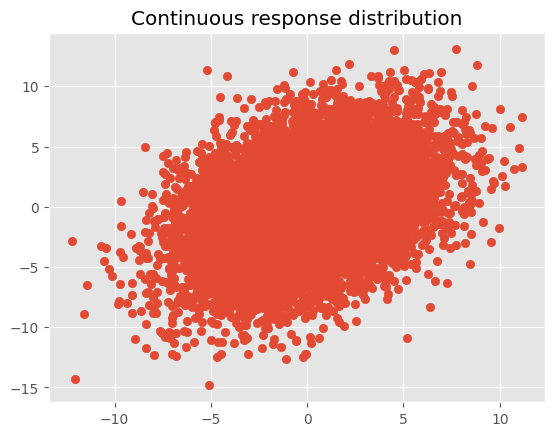

In [4]:
plt.scatter(y_star_mu[:, 0], y_star_mu[:, 1])
print(jnp.corrcoef(y_star_mu.T))
plt.title("Continuous response distribution")
plt.show()

We use random covariates and a correlation on the residuals of $0.9$. We can see that $\epsilon$ exhibits this correlation.
The correlation in $y^*$ is attributable to X and the residuals (note the different scales on the two plots).

## Fitting marginals

Let's use the property that each marginal response can be fitted with a univariate probit regression.

In [5]:
# Fitting without correlation
# This loss assumes independence of outcomes given X

def loss(beta, x, y):
    w = x @ beta
    
    logcdf = jax.scipy.stats.norm.logcdf(w)
    logsf = jax.scipy.stats.norm.logcdf(-w)
    
    log_prob = y * logcdf + (1 - y) * logsf
    return -jnp.sum(log_prob) / y.shape[0]

loss(beta, x, y)

Array(0.43492714, dtype=float32)

In [6]:
# We optimize using BFGS, which requires a flat vector.
import jax.scipy.optimize as sco

def loss2(beta_flat):
    beta = beta_flat.reshape((p, q))
    return loss(beta, x, y)

res = sco.minimize(loss2, jnp.zeros((p*q, )), method="BFGS")
beta_hat = res.x.reshape((p, q))

In [7]:
# We compute the standard error using the hessian (see also JAX Recipe II)
h_beta = jax.hessian(loss2)(res.x)
beta_hat_std = jnp.sqrt(jnp.diag(jnp.linalg.inv(h_beta) / n)).reshape((p, q))

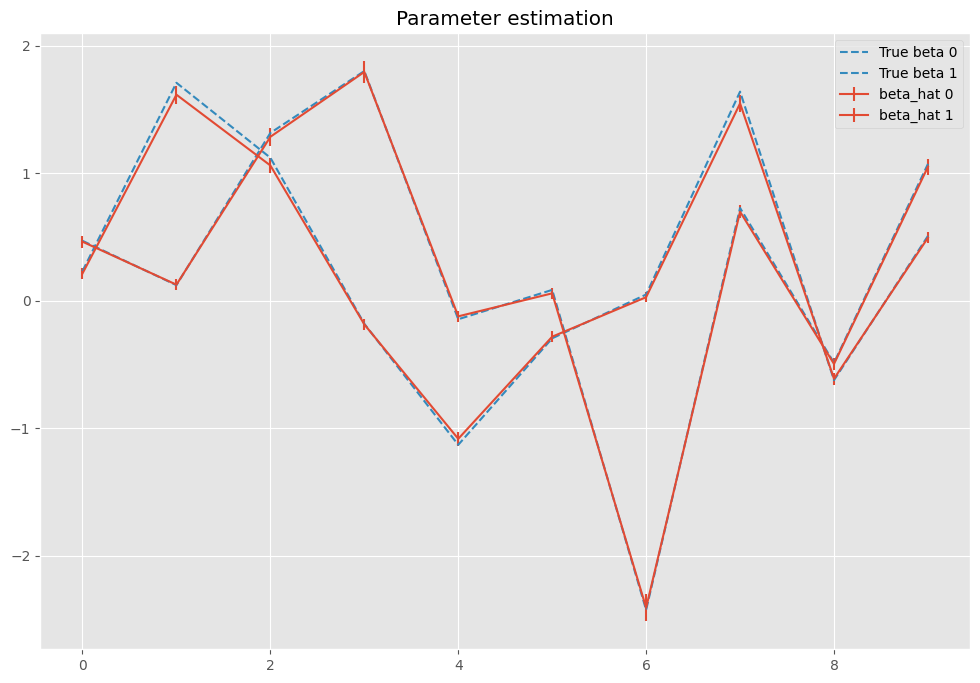

In [8]:
plt.figure(figsize=(12, 8))

for i in range(q):
    plt.errorbar(range(p), beta_hat[:, i], yerr=1.96 * beta_hat_std[:, i], color='C0', label=f'beta_hat {i}')
    plt.plot(beta[:, i], color='C1', linestyle='--', label=f'True beta {i}')

plt.legend()
plt.title("Parameter estimation")
plt.show()

In [9]:
z_scores = (beta_hat - beta) / beta_hat_std
z_scores.mean(), z_scores.std()

(Array(-0.52653337, dtype=float32), Array(1.0804694, dtype=float32))

We can see that the fitted values are close to the truth. Standard errors are computed from the hessian, they visually have the right scale and the z-scores have a standard error close to 1. All those things seem to indicate a good fit.

Are we missing a lot of correlation from there? We should be able to tell by taking a look at the residuals from the univariate regressions.

In [10]:
p_y_hat = jax.scipy.stats.norm.cdf(x @ beta_hat)
residuals = y - p_y_hat
jnp.corrcoef(residuals.T)

Array([[1.        , 0.19038962],
       [0.19038962, 1.        ]], dtype=float32)

There is indeed about 19% of correlation that is not explained by the covariates in $X$.

Another way to put this effect in perspective is by comparing the probability of both responses being = 1 according to the raw data and the model.


In [11]:
# P(Y1 = 1 and Y2 = 1)

p11 = jnp.mean(jnp.all(y == 1, axis=1))
p11_std = jnp.sqrt(p11 * (1 - p11) / n)

p11 + 1.96 * p11_std * jnp.array([-1, +1])

Array([0.2975628, 0.3156372], dtype=float32)

In [12]:

p11_uni = jnp.mean(jnp.prod(p_y_hat, axis=1))
# This does not take into account noise introduced by the estimation of beta
p11_uni_std = jnp.std(jnp.prod(p_y_hat, axis=1)) / jnp.sqrt(n)

p11_uni + 1.96 * p11_uni_std * jnp.array([-1, +1])

Array([0.28471676, 0.29951128], dtype=float32)

The two confidence intervals overlap sightly, and while the test is not completely rigorous (given that both estimators are correlated), assuming independence does seem to lead to a slight underestimation of $p_{11}$.
Depending on the usecase, it might make sense to stop here. We are going to investigate the correlation structure further and see if we can come up with better estimates and model fit.



## Fitting the correlation structure

The normal distribution is probably the easiest distribution to work with in higher dimensions with correlations. However, the truncation part of the probit model creates a lot of problems when trying to estimate parameters. If the shape of the likelihood is not too disturbed by the truncation, the normalizing constants are obviously impacted and when $q$ is greater than $2$, no analytical formula can be used to write down the likelihood of a multivariate probit model.
There exists significant litterature on those issues. Here I would like to showcase one of the easier and more scalable idea - even though there are always going to be scalability problems with such models-.

In {cite}`ICML-2018-ChenXG`, Chen showcases how splitting the covariance matrix into a diagonal and a residual part can help estimate the likelihood by sampling from a normal distribution without truncation. They then show that the diagonal matrix can be reduced to the identity and it only suffices to estimate the residual covariance.

$\Sigma = I_q + \Sigma_r $ and $\Sigma_r = s^Ts$ so that $\Sigma_r$ is constrained to be positive semi definite, i.e. a valid covariance matrix.

In JAX, the parameters can be regrouped in a NamedTuple as follows, with $\beta$ and $s$ being the unconstrained parameters, and $\Sigma$ being completely specified by $s$.

In [13]:
class Params(NamedTuple):
    beta: jnp.array
    s: jnp.array
    
    @property
    def sigma(self):
        """Computes sigma from the square root of its residual, `s`."""
        s = self.s
        t = s.T @ s
        S = t + jnp.eye(q)
        sqrt_diag = jnp.sqrt(jnp.diag(S))
        # Normalize Sigma to a correlation matrix
        S = (S / sqrt_diag).T / sqrt_diag
        return S

true_params = Params(beta=beta, s=sqrt_r)
true_params, true_params.sigma

(Params(beta=Array([[ 0.23186858,  0.46960872],
        [ 1.709085  ,  0.12174629],
        [ 1.1210241 ,  1.3156708 ],
        [-0.1811214 ,  1.8010722 ],
        [-1.1304141 , -0.14554782],
        [-0.29495806,  0.08470398],
        [ 0.04848719, -2.4250152 ],
        [ 1.6395696 ,  0.7269019 ],
        [-0.6232631 , -0.48760355],
        [ 0.5079111 ,  1.0722051 ]], dtype=float32), s=Array([[2.1213205, 2.1213202],
        [2.1213202, 2.1213202]], dtype=float32)),
 Array([[1.        , 0.90000004],
        [0.90000004, 1.        ]], dtype=float32))

From there, Chen shows that the likelihood can be estimated with a Monte Carlo estimator based on samples of the normal distribution. See the paper for details. It is worth noting that if $s = 0$ then the loss is exactly the same as the univariate fits described earlier.

We note $m$ the number of Monte-Carlo samples used per sample for each evaluation of the loss / log-likelihood.

In [14]:
from functools import partial

@partial(jax.jit, static_argnums=(4,))
def loss(params, x, y, key, m=100):
    beta, s = params.beta, params.s
    
    z = random.normal(key, (m, x.shape[0], y.shape[1]))
    sigma_scale = jnp.sqrt(jnp.diag(jnp.eye(q) + s.T.dot(s)))

    w = x @ beta * sigma_scale  + z.dot(s)
    
    logcdf = jax.scipy.stats.norm.logcdf(w)
    logsf = jax.scipy.stats.norm.logcdf(-w)
    
    phi = y * logcdf + (1 - y) * logsf
    prod_phi = jnp.exp(phi.sum(axis=-1))
    prob = prod_phi.mean(axis=0)
    return -jnp.mean(jnp.log(prob))


In [15]:
%%time
loss(true_params, x, y, key, m=1000)

CPU times: user 4.8 s, sys: 138 ms, total: 4.94 s
Wall time: 933 ms


Array(0.4146354, dtype=float32)

At the true parameters, the loss is smaller than the optimal loss found for the univariate fits.
This _at least_ proves that a model with correlation fits better than a model with independent marginals.

However, even after JIT compilation, computing the loss can take half a second with $m=1000$ Monte Carlo samples. This can be a bit slow when trying to find the right parameters. We will adopt a flexible approach that will try to minimize fitting time.

### Parameter estimation

We choose to minimize the loss by stochastic gradient descent with momentum. The loss being stochastic (because of the Monte-Carlo estimation), gradient methods are more robust. Second order methods use too noisy information in those cases to be reliable. Momentum however is a good idea to smooth the gradient over several iterations of training, which is ideal in cases where the loss has some randomness. Finally the stochastic aspect of the descent (by which we mean using batches of data points instead of the entire dataset at each iteration) will help shorten the computation time of the loss and its gradient.

Here is the proposed procedure:

In [16]:
import optax

def fit_params(
    init_params, x, y, key,
    n_iterations = 100,
    batch_size = 100,
    lr = 1.0,
    momentum=.9,
    m=100,
):
    params = init_params
    hist = {'f': [], 'g_norm': []}
    optimizer = optax.sgd(learning_rate=lr, momentum=momentum)
    opt_state = optimizer.init(params)
    
    @jax.jit
    def update(params, x, y, key, opt_state):
        f, g = jax.value_and_grad(loss)(params, x, y, key, m)
        updates, opt_state = optimizer.update(g, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, f, jnp.linalg.norm(g.beta)
    
    for i in range(n_iterations):
        key, skey = random.split(key)
        j = i % (y.shape[0] // batch_size)
        x_batch = x[j * batch_size: (j + 1) * batch_size]
        y_batch = y[j * batch_size: (j + 1) * batch_size]
        
        params, opt_state, f, g_norm = update(params, x_batch, y_batch, skey, opt_state)
        hist['f'].append(f)
        hist['g_norm'].append(g_norm)
    
    hist['f'] = jnp.stack(hist['f'])
    hist['g_norm'] = jnp.stack(hist['g_norm'])
    
    return params, hist


In [17]:
import optax


def create_batches(x, y, key, batch_size):
    n = x.shape[0]
    n_iterations = n // batch_size
    perm = random.permutation(key, n)
    for i in range(n_iterations):
        x_batch = x[perm[i * batch_size: (i + 1) * batch_size]]
        y_batch = y[perm[i * batch_size: (i + 1) * batch_size]]
        yield x_batch, y_batch


def fit_params(
    init_params, x, y, key,
    n_epochs = 10,
    batch_size = 100,
    lr = 1.0,
    momentum=.9,
    m=100,
):
    params = init_params
    hist = {'f': [], 'g_norm': []}
    optimizer = optax.sgd(learning_rate=lr, momentum=momentum)
    opt_state = optimizer.init(params)
    
    @jax.jit
    def update(params, x, y, key, opt_state):
        f, g = jax.value_and_grad(loss)(params, x, y, key, m)
        updates, opt_state = optimizer.update(g, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, f, jnp.linalg.norm(g.beta)
    
    for e in range(n_epochs):
        key, skey = random.split(key)
        for x_batch, y_batch in create_batches(x, y, skey, batch_size):
            key, skey = random.split(key)
            params, opt_state, f, g_norm = update(params, x_batch, y_batch, skey, opt_state)
            hist['f'].append(f)
            hist['g_norm'].append(g_norm)
    
    hist['f'] = jnp.stack(hist['f'])
    hist['g_norm'] = jnp.stack(hist['g_norm'])
    
    return params, hist


We want to start with `m` and `batch_size` as low as possible to minimize compute times, and increase them if the loss is too unstable to be optimized.
Both will also influence memory footprint (on CPU and on GPU), therefore picking the highest values that fill your memory is another interesting option. 

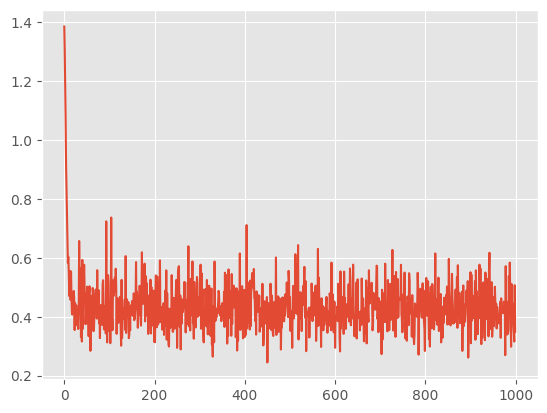

avg loss:  0.4296| std loss  0.0733
CPU times: user 13 s, sys: 1.33 s, total: 14.3 s
Wall time: 5.78 s


In [18]:
%%time

params = Params(
    beta=jnp.zeros((p, q)),
    s=jnp.zeros((q, q)),
)

key, skey = random.split(key)
params, hist = fit_params(params, x, y, skey, n_epochs=10, batch_size=100, lr=0.1, m=100)
plt.plot(hist['f'])
plt.show()

print(
    f"avg loss: {hist['f'][-100:].mean(): .4f}"
    f"| std loss {hist['f'][-100:].std(): .4f}"
)

Loss is at 42.6. And we quickly hit a stage where the loss is stable and noisy.
We have three choices:
- decrease learning rate
- increase `m`
- increase `batch_size`

(In certain cases, it can help to increase the learning rate, but I would consider it a last resort outside of documented cases).

Therefore, let's follow this method and reduce the learning rate:

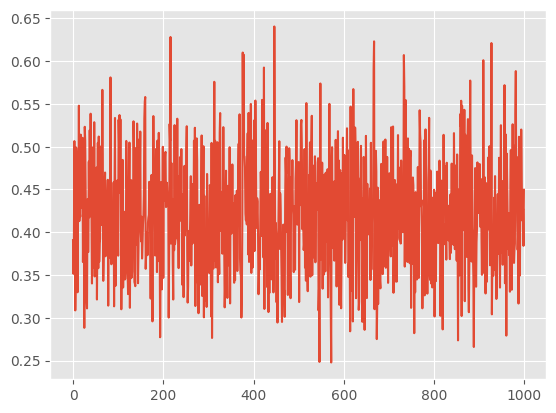

avg loss:  0.4228| std loss  0.0672


In [19]:
saved_params = params

key, skey = random.split(key)
params, hist = fit_params(params, x, y, skey, n_epochs=10, batch_size=100, lr=0.03, m=100)
plt.plot(hist['f'])
plt.show()

print(
    f"avg loss: {hist['f'][-100:].mean(): .4f}"
    f"| std loss {hist['f'][-100:].std(): .4f}"
)

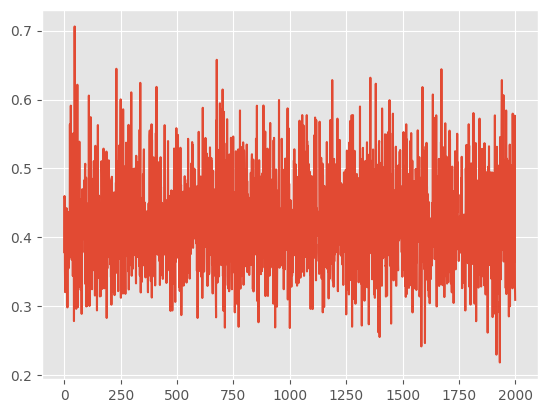

avg loss:  0.4206| std loss  0.0841


In [20]:
# Loss dropped at 41.90, let's train for longer:

saved_params = params

key, skey = random.split(key)
params, hist = fit_params(params, x, y, skey, n_epochs=20, batch_size=100, lr=0.03, m=100)
plt.plot(hist['f'])
plt.show()

print(
    f"avg loss: {hist['f'][-100:].mean(): .4f}"
    f"| std loss {hist['f'][-100:].std(): .4f}"
)

Loss increased slightly. Let's see what's better between increasing batch size and monte-carlo samples.

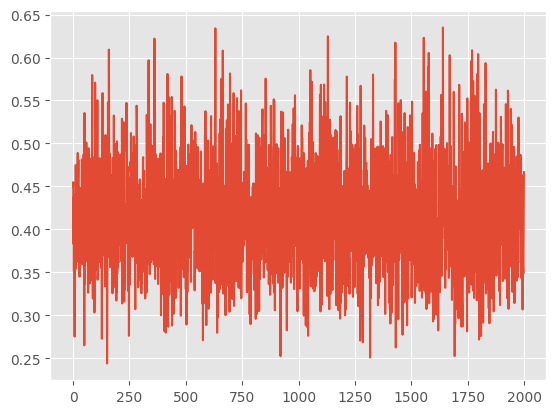

avg loss:  0.4175| std loss  0.0580


In [21]:
saved_params = params

key, skey = random.split(key)
params, hist = fit_params(params, x, y, skey, n_epochs=20, batch_size=100, lr=0.03, m=1000)
plt.plot(hist['f'])
plt.show()

print(
    f"avg loss: {hist['f'][-100:].mean(): .4f}"
    f"| std loss {hist['f'][-100:].std(): .4f}"
)

Loss decreased slightly. Let's load the previous checkpoint and test increasing batch size.


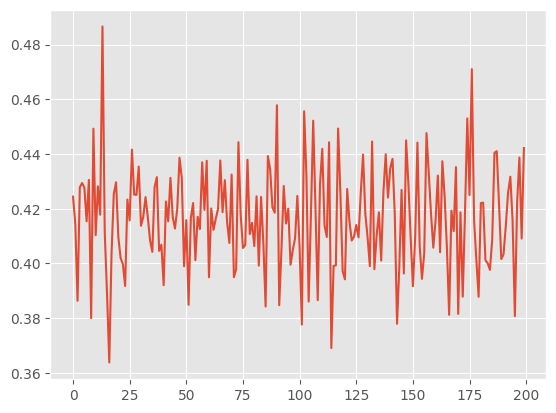

avg loss:  0.4164| std loss  0.0199


In [22]:
params = saved_params

key, skey = random.split(key)
params, hist = fit_params(params, x, y, skey, n_epochs=20, batch_size=1000, lr=0.03, m=100)
plt.plot(hist['f'])
plt.show()

print(
    f"avg loss: {hist['f'][-100:].mean(): .4f}"
    f"| std loss {hist['f'][-100:].std(): .4f}"
)

Loss decreased, and its standard error is much lower. Let's train this way for longer:

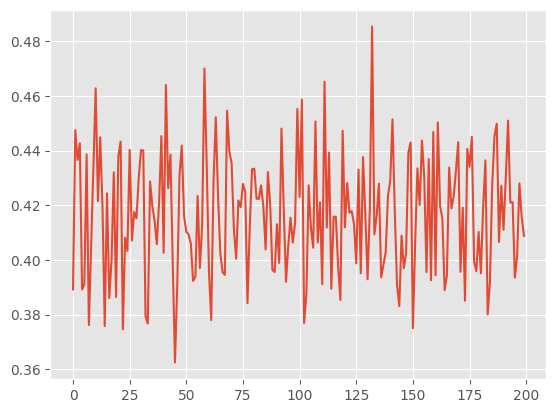

avg loss:  0.4171| std loss  0.0216


In [23]:
saved_params = params

key, skey = random.split(key)
params, hist = fit_params(params, x, y, skey, n_epochs=20, batch_size=1000, lr=0.03, m=100)
plt.plot(hist['f'])
plt.show()

print(
    f"avg loss: {hist['f'][-100:].mean(): .4f}"
    f"| std loss {hist['f'][-100:].std(): .4f}"
)

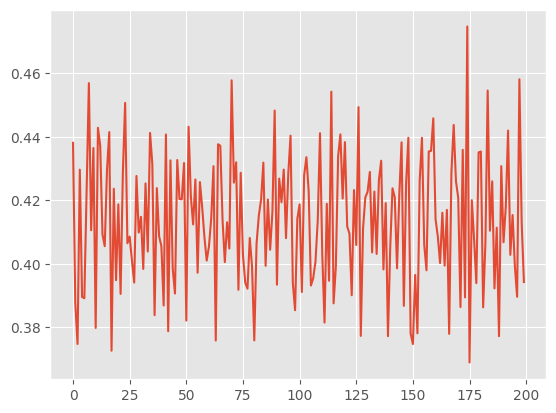

avg loss:  0.4135| std loss  0.0214
CPU times: user 3min 2s, sys: 25.2 s, total: 3min 28s
Wall time: 38.9 s


In [24]:
%%time

# loss is stable again. Let's try to increase MC samples

saved_params = params

key, skey = random.split(key)
params, hist = fit_params(params, x, y, skey, n_epochs=20, batch_size=1000, lr=0.03, m=1000)
plt.plot(hist['f'])
plt.show()

print(
    f"avg loss: {hist['f'][-100:].mean(): .4f}"
    f"| std loss {hist['f'][-100:].std(): .4f}"
)

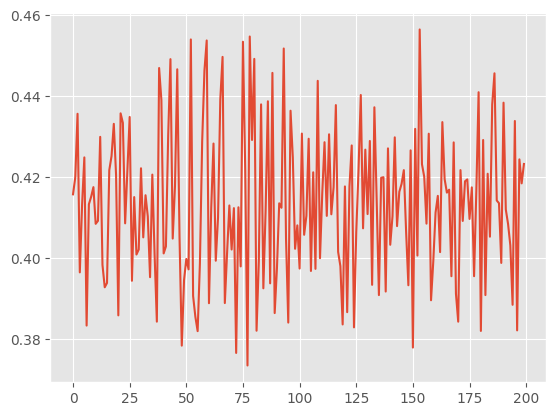

avg loss:  0.4135| std loss  0.0164
CPU times: user 3min, sys: 25.5 s, total: 3min 26s
Wall time: 38.9 s


In [25]:
%%time
# Loss improved, let's keep going

saved_params = params

key, skey = random.split(key)
params, hist = fit_params(params, x, y, skey, n_epochs=20, batch_size=1000, lr=0.03, m=1000)
plt.plot(hist['f'])
plt.show()

print(
    f"avg loss: {hist['f'][-100:].mean(): .4f}"
    f"| std loss {hist['f'][-100:].std(): .4f}"
)

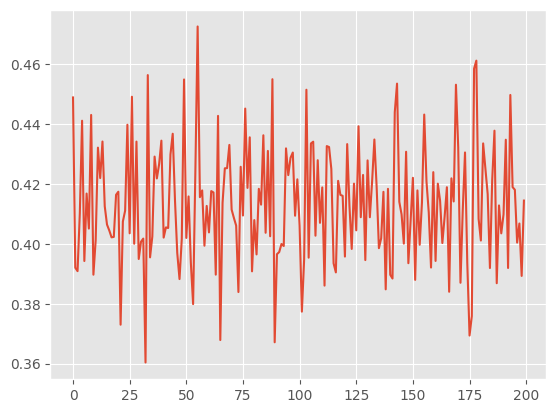

avg loss:  0.4132| std loss  0.0192
CPU times: user 2min 52s, sys: 25.2 s, total: 3min 17s
Wall time: 38.2 s


In [26]:

%%time
# Loss is stable. Compute time is as high as I am willing to wait. Let's try to reduce learning rate.

saved_params = params

key, skey = random.split(key)
params, hist = fit_params(params, x, y, skey, n_epochs=20, batch_size=1000, lr=0.01, m=1000)
plt.plot(hist['f'])
plt.show()

print(
    f"avg loss: {hist['f'][-100:].mean(): .4f}"
    f"| std loss {hist['f'][-100:].std(): .4f}"
)

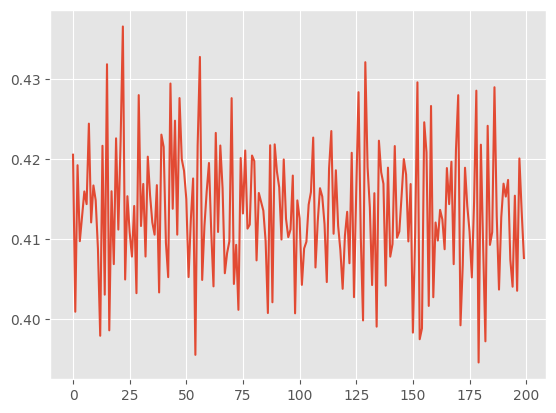

avg loss:  0.4129| std loss  0.0080
CPU times: user 11min 13s, sys: 1min 25s, total: 12min 39s
Wall time: 2min 14s


In [27]:

%%time
# Loss is stable. Compute time is as high as I am willing to wait. Let's try to reduce learning rate.

saved_params = params

key, skey = random.split(key)
params, hist = fit_params(params, x, y, skey, n_epochs=100, batch_size=4000, lr=0.01, m=1000)
plt.plot(hist['f'])
plt.show()

print(
    f"avg loss: {hist['f'][-100:].mean(): .4f}"
    f"| std loss {hist['f'][-100:].std(): .4f}"
)

Loss has stopped improving. We can keep going to try to minimize further, but we reached a decent point. Let's consider this model trained and pursue our analysis.


### Point estimates


In [28]:
params.sigma

Array([[1.        , 0.82707417],
       [0.82707417, 1.        ]], dtype=float32)

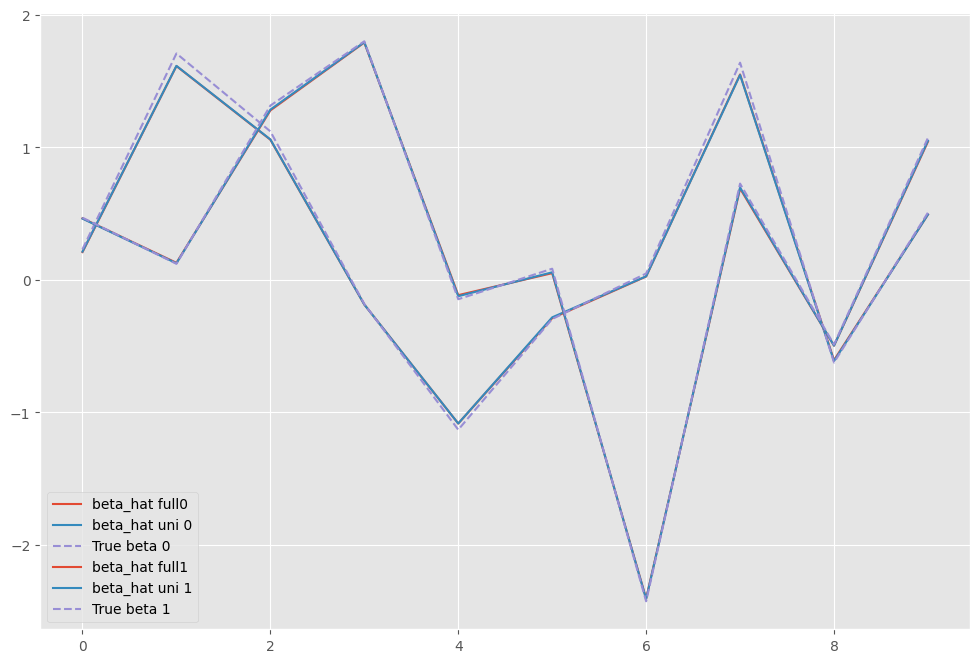

In [29]:
plt.figure(figsize=(12, 8))

for i in range(q):
    plt.plot(range(p), params.beta[:, i], color='C0', label=f'beta_hat full{i}')
    plt.plot(range(p), beta_hat[:, i], color='C1', label=f'beta_hat uni {i}')
    plt.plot(beta[:, i], color='C2', linestyle='--', label=f'True beta {i}')

plt.legend()
plt.show()


The correlation is at 83%, while the truth is at 90%.
$\beta$ as estimated from the full model is undistiguishable from $\beta$ estimated by univariate methods.

The point estimates are therefore convincing. The optimal loss is at 0.413 which is smaller than the loss at the true values (0.4146)

### Confidence intervals

Eventhough the loss function is evaluated by a Monte-Carlo method, and the optimization is complex. We propose the following way to get confidence intervals for each parameters.

For $\beta$ we can essentially follow the same hessian-based method as the univariate methods:


In [30]:
# standard errors on beta

def loss3(beta_flat):
    beta = beta_flat.reshape(p, q)
    return loss(Params(beta=beta, s=params.s), x, y, key, m=2000)

h_beta = jax.jit(jax.hessian(loss3))(params.beta.flatten())
std_beta = jnp.sqrt(jnp.diag(jnp.linalg.inv(h_beta) / n))
std_beta = std_beta.reshape(p, q)


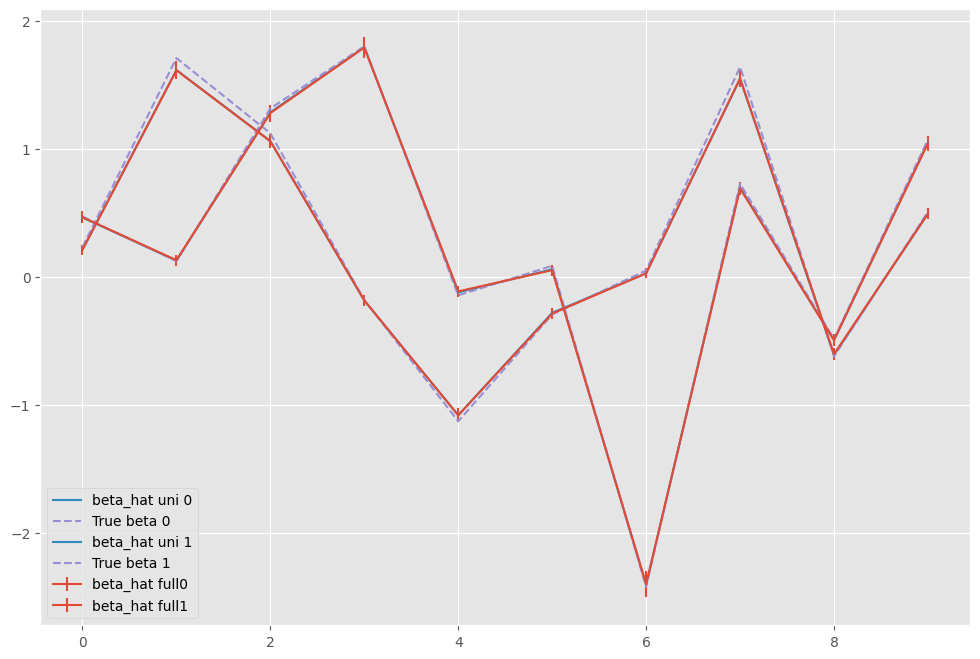

(Array(-0.5751055, dtype=float32), Array(1.1819036, dtype=float32))

In [31]:
plt.figure(figsize=(12, 8))

for i in range(q):
    plt.errorbar(range(p), params.beta[:, i], yerr=1.96 * std_beta[:, i], color='C0', label=f'beta_hat full{i}')
    plt.plot(range(p), beta_hat[:, i], color='C1', label=f'beta_hat uni {i}')
    plt.plot(beta[:, i], color='C2', linestyle='--', label=f'True beta {i}')

plt.legend()
plt.show()

z_scores = (params.beta - beta) / std_beta
z_scores.mean(), z_scores.std()

The standard errors look reasonable and the z-scores have a standard error of around 1.2, where we would have expected something closer to 1.
They may therefore a bit larger than what they should be.


#### Confidence interval for $\Sigma$ (Work in progress)
Getting a confidence interval for the correlation may prove a bit harder since we estimated $s$ which is an overparametrization of the covariance matrix. An other difficulty is that it is more complicated to get $s$ from sigma than the reverse. To get $s$ from $\Sigma$, we need to find the square root of the matrix, which can involve diagonilisation and heavier linear algebra. This heavier linear algebra is in particular more difficult to differentiate (at least for JAX) and my attempts to directly write the likelihood as a function of $\Sigma$ have failed.

It is, however significantly easier to transform $s$ to $\Sigma$ by the function we laid out during the parametrization step. The idea is therefore to use the Delta method on the approximate distribution that $s$ follows to get an approximate normal distribution for $\Sigma$. Here since $q=2$, we will focus on the only off-diagonal term $\rho$ which is the correlation between the two residual responses.



In [32]:
# First, let's estimate the distribution of s

key, skey = random.split(key)

def loss2(s_flat):
    s = s_flat.reshape(q, q)
    return loss(Params(beta=params.beta, s=s), x, y, key, m=2000)

hloss2 = jax.jit(jax.hessian(loss2))
h = hloss2(params.s.flatten())
cov_s = jnp.linalg.inv(h) / n
cov_s

Array([[-0.05073601, -0.09917498, -0.08121364, -0.04659434],
       [-0.09917454, -0.04345205, -0.04309906, -0.08628308],
       [-0.08121356, -0.04309898,  0.0459978 , -0.04623628],
       [-0.04659341, -0.08628242, -0.04623552,  0.04944843]],      dtype=float32)

Now, we are supposed to have the covariance of $s$ (per the maximum likelihod estimation).

Thanks to the Delta method, if $\hat s \sim N(s, \Sigma_s)$ and $\rho = f(s)$
then we should have $$ \hat \rho = f(\hat s) \sim N(f(s) = \rho, \nabla_s f^T  \Sigma_s \nabla_s f)$$ as long as the variations of $s$ are within a fairly linear portion of $f$.

In [33]:
# s to rho
def s_to_rho(s_flat):
    s = s_flat.reshape(q, q)
    t = s.T @ s
    S = t + jnp.eye(q)
    sqrt_diag = jnp.sqrt(jnp.diag(S))
    S = (S / sqrt_diag).T / sqrt_diag
    return S[0, 1]

s_to_rho(params.s)
g_s = jax.grad(s_to_rho)(params.s.flatten())
v_rho = g_s.T @ cov_s @ g_s
std_rho = jnp.sqrt(v_rho)
std_rho

Array(0.02546195, dtype=float32)

This seems to conclude that the standard error on $\hat \rho$ is about 3%.
It is a bit hard to validate since bootstrapping would be very slow. At a minimum, it is believeable.

Note that there are unadressed theoretical problems with this approach: 
- The attentive reader may have noticed that the "Covariance" for $s$ is not positive semi-definite. This prevents it from being a valid covariance matrix. Moreover, maximum likelihood estimation applies when the model is identifiable, which is not the case here as several different s can lead to the same $\Sigma$.
- Nonetheless, when repeating the computation with different random seeds, the standard error for rho is stable, which at least does not indicate any numerical instability. 
- There is therefore work to be done to confirm or falsify this procedure to get standard errors for $\rho$.


Let's plot the loss as a function of rho

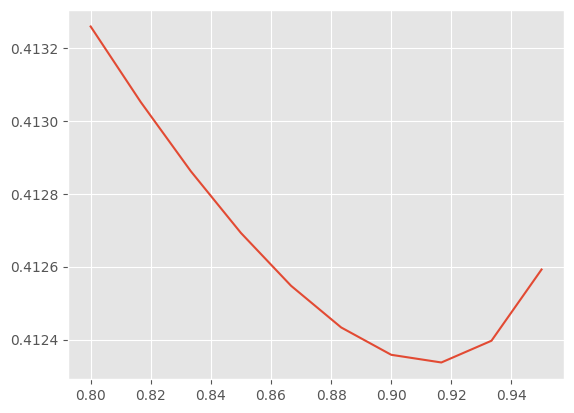

In [34]:
def rho_to_s(rho):
    sigma = jnp.array([
        [1.0, rho],
        [rho, 1.0],
    ])

    r = sigma / (1 - rho) - jnp.eye(q)
    sqrt_r = jnp.real(jax.scipy.linalg.sqrtm(r))
    return sqrt_r


losses = []
rho_s = jnp.linspace(.80, .95, num=10)
for rho in rho_s:
    # key, skey = random.split(key)
    losses.append(loss(Params(beta=params.beta, s=rho_to_s(rho)), x, y, skey, m=4_000))

plt.plot(rho_s, losses)

Graphically, there seems to be an obvious minimum at 91 (close to 90 +/- 3%). However, our procedure estimated 82.5%.
Clearly optimizing the noisy loss function is not trivial!


## Bonus: E-M Algorithm with Rejection sampling

Given the hierachical nature of the model, some form of E-M algorithm can be used to fit parameters.
One of the main advantage is that gradients are not needed for this procedure. 
One of the drawback is that it relies on the ability to sample from a truncated normal distribution in a decent amount of time.
There is a vast litterature on sampling from truncated normal, and it is generally not an easy task.
Here, we can implement it using rejection sampling. That is to say, we sample from the desired normal distribution until the sample falls in the right quadrant of the space.
This makes the procedure compute in random time. The probability of a single step being successful will be proportional to the amount of probability mass that remains within the desired quadrant.

For more details, see [Wikipedia](https://en.wikipedia.org/wiki/Probit_model#Gibbs_sampling)

The following  procedure can be used to sample from a truncated normal distribution:


In [35]:
import jax.lax as lax

# want to count number of trials before getting a sample

def trunc_normal_once(key, y, mean, sqrt_cov):
    """Basic rejection sampling"""
    key, skey = random.split(key)
    u = mean + sqrt_cov @ random.normal(skey, y.shape)
    
    def cond(state):
        key, u, n = state
        return jnp.any(u * y < 0)
    
    def body(state):
        key, u, n = state
        key, skey = random.split(key)
        u = mean + sqrt_cov @ random.normal(skey, y.shape)
        n += 1
        return key, u, n
    
    key, u, n = lax.while_loop(cond, body, (key, u, 1))
    return u, n

@jax.jit
def trunc_normal(key, y, mean, cov):
    sqrt_cov = jnp.real(jax.scipy.linalg.sqrtm(cov))
    keys = random.split(key, y.shape[0])
    y = (y - .5) * 2
    u = jax.vmap(trunc_normal_once, in_axes=(0, 0, 0, None))(keys, y, mean, sqrt_cov)
    return u

In [36]:
mean = x @ beta
sigma

Array([[1. , 0.9],
       [0.9, 1. ]], dtype=float32)

Using this procedure, we can sample a likely $y^*$ given $y$, $\beta$ and $\Sigma$ 

In [37]:
%%time
y_star_sample, _ = trunc_normal(key, y, mean, sigma)

CPU times: user 6.89 s, sys: 1.53 s, total: 8.42 s
Wall time: 2.82 s


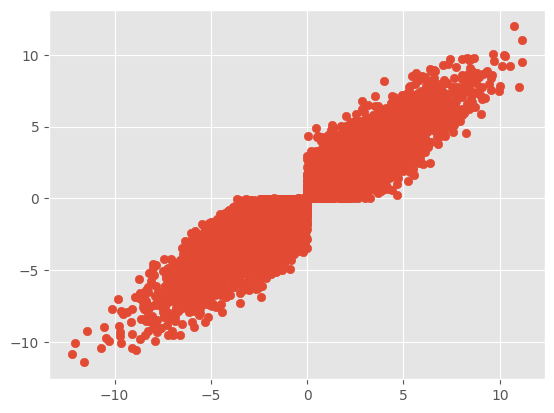

In [38]:
# To sanity check, we can plot the sample against its expected value
plt.scatter(y_star_mu[:, 0], y_star_sample[:, 0])
plt.show()


From there, it is easy to check that $y^*$ has the desired variance and correlation.

In [39]:
eps = y_star_sample - mean
jnp.mean(eps, axis=0), jnp.std(eps, axis=0), jnp.corrcoef(eps.T)

(Array([-0.0016255 ,  0.00129633], dtype=float32),
 Array([1.0060968, 1.0028441], dtype=float32),
 Array([[1.       , 0.9011806],
        [0.9011806, 1.       ]], dtype=float32))

If we know $y^*$ and $x$, it is easy to estimate $\beta$, since the problem is a simple linear regression in the continuous / starred space.

In [40]:
# fit multivariate linear regression
beta_hat = jnp.linalg.solve(x.T @ x, x.T @ y_star_mu)

In [41]:
# Check correctness
beta_hat / beta

Array([[1.0243322 , 1.0189387 ],
       [0.9974448 , 0.97601026],
       [0.9831262 , 0.9877366 ],
       [1.0184389 , 0.99906915],
       [0.99103063, 0.9252699 ],
       [0.98279214, 1.0952549 ],
       [0.6354604 , 1.0071455 ],
       [0.99918485, 1.0012058 ],
       [1.0074484 , 1.0122432 ],
       [0.9906767 , 0.9956854 ]], dtype=float32)

We now have all the tools to fit the mutlivariate probit using E-M / Gibbs sampling.
The idea is to iterate the following steps:
- given a candidate $\hat\beta$, and $y$, we sample $\hat y^*$ from the corresponding truncated normal
- given the new candidate $\hat y^*$, we compute a new $\hat\beta$ by solving a linear regression in the continuous / starred space.

The following procedure implements this idea:

In [43]:
%%time

# attempt at fitting by EM

from time import time

def fit_em(key):
    beta_hat = jnp.zeros((x.shape[1], y.shape[1]))
    sigma_hat = jnp.eye(y.shape[1])
    start = time()
    hist = {
        'beta': [beta_hat],
        'sigma': [sigma_hat],
    }
    
    for i in range(100 + 1):
        mean = x @ beta_hat
        key, skey = random.split(key)
        
        y_star_sample, n_interations = trunc_normal(skey, y, mean, sigma_hat)
        beta_hat = jnp.linalg.solve(x.T @ x, x.T @ y_star_sample)
        eps = y_star_sample - mean
        sigma_hat = jnp.corrcoef(eps.T)
        sqrt_diag = jnp.sqrt(jnp.diag(sigma_hat))
        sigma_hat = (sigma_hat / sqrt_diag).T / sqrt_diag
        
        hist['beta'].append(beta_hat)
        hist['sigma'].append(sigma_hat)
        
        if i % 10 == 0:
            print(f"{i=}, "
                  f"norm(beta_hat - beta)={jnp.linalg.norm(beta_hat - beta): .2f}, "
                  f"rho={sigma_hat[0, 1]: .2f}, "
                  f"iteration_time={time() - start: .2f}, "
                  f"max_n_iterations={n_interations.max(): .2f}"
                  )
            start = time()
    return beta_hat, sigma_hat, hist

beta_hat, sigma_hat, hist = fit_em(key)

i=0, norm(beta_hat - beta)= 3.85, rho= 0.14, iteration_time= 0.07, max_n_iterations= 35.00
i=10, norm(beta_hat - beta)= 2.05, rho= 0.22, iteration_time= 0.74, max_n_iterations= 82.00
i=20, norm(beta_hat - beta)= 1.44, rho= 0.26, iteration_time= 2.69, max_n_iterations= 90.00
i=30, norm(beta_hat - beta)= 1.14, rho= 0.35, iteration_time= 5.03, max_n_iterations= 268.00
i=40, norm(beta_hat - beta)= 0.91, rho= 0.39, iteration_time= 4.74, max_n_iterations= 296.00
i=50, norm(beta_hat - beta)= 0.71, rho= 0.46, iteration_time= 11.10, max_n_iterations= 744.00
i=60, norm(beta_hat - beta)= 0.56, rho= 0.53, iteration_time= 11.12, max_n_iterations= 500.00
i=70, norm(beta_hat - beta)= 0.45, rho= 0.57, iteration_time= 7.79, max_n_iterations= 400.00
i=80, norm(beta_hat - beta)= 0.37, rho= 0.61, iteration_time= 14.60, max_n_iterations= 2548.00
i=90, norm(beta_hat - beta)= 0.37, rho= 0.65, iteration_time= 8.48, max_n_iterations= 785.00
i=100, norm(beta_hat - beta)= 0.42, rho= 0.70, iteration_time= 11.90, 

We can see that within a minute, we get closer to the real $\beta$, and that $\rho$ is getting closer to its real value.
Notice that iteration time also steadily increases. This is because it becomes harder and harder to sample from the truncated normal.
The probability to fall in the right quadrant is smaller and smaller because the correlation is higher.
In practice, this procedure converges to the right answer in about 2 hours because of the sampling bottleneck!
There is no free lunch here, the gradient-based version leads to a noisy loss, and the sampling procedure yields to a slow convergence.

One advantage of the gradient method is that it can be directly plugged into a deep neural network.
In the E-M case, the neural net would have to learn from data that keeps being sampled. I am not sure if that's better or worse, it's simply different.


## Conclusion

- In this post, we discovered the multivariate probit, and its elegant formulation as the discretization of a nice, continuous problem.
- We saw how the discretization poses major issues to gradient-based optimizations as well as sampling based inference.
- JAX helped us get the most of our compute platform by jitting most functions, and computing gradients through monte-carlo estimates.

I hope this adds a string to your bow!
